In [7]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

%matplotlib inline
#%matplotlib notebook
plt.rcParams["figure.figsize"] = (10,6)
import warnings
warnings.filterwarnings("ignore")
warnings.warn("this will not show")
pd.set_option('display.float_format', lambda x: '%.3f' % x)

In [3]:
df = pd.read_csv("Advertising.csv")
df.head()

,TV,radio,newspaper,sales
0,230.1,37.8,69.2,22.1
1,44.5,39.3,45.1,10.4
2,17.2,45.9,69.3,9.3
3,151.5,41.3,58.5,18.5
4,180.8,10.8,58.4,12.9


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200 entries, 0 to 199
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   TV         200 non-null    float64
 1   radio      200 non-null    float64
 2   newspaper  200 non-null    float64
 3   sales      200 non-null    float64
dtypes: float64(4)
memory usage: 6.4 KB


In [5]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
TV,200.0,147.0425,85.854236,0.7,74.375,149.75,218.825,296.4
radio,200.0,23.2640,14.846809,0.0,9.975,22.90,36.525,49.6
newspaper,200.0,30.5540,21.778621,0.3,12.750,25.75,45.100,114.0
sales,200.0,14.0225,5.217457,1.6,10.375,12.90,17.400,27.0


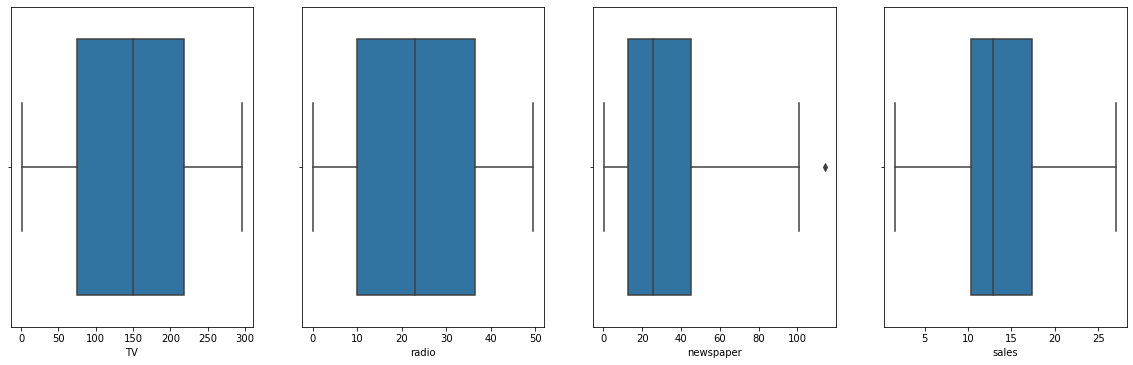

In [12]:
index = 0
plt.figure(figsize=(20,20))
for i in df.columns:
    index += 1
    plt.subplot(3,4,index)
    sns.boxplot(df[i], whis=1.8)

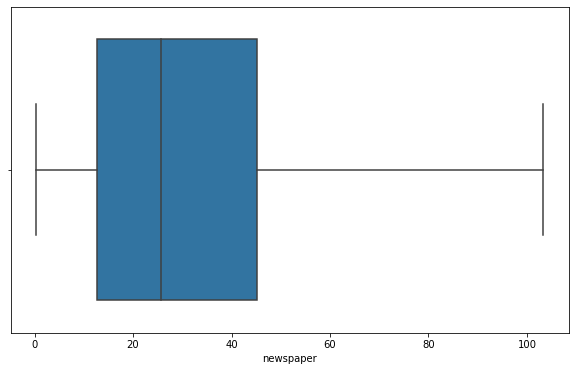

In [14]:
for i in df.select_dtypes([float, int]).columns:
    if i == "newspaper" :
        Q1 = df[i].quantile(0.25)
        Q3 = df[i].quantile(0.75)
        IQR = Q3-Q1
        alt_sinir = Q1-(1.8*IQR)
        ust_sinir = Q3+(1.8*IQR)
        aykiri_alt = df[i] < alt_sinir
        aykiri_ust = df[i] > ust_sinir
        df[i][aykiri_alt] = alt_sinir
        df[i][aykiri_ust] = ust_sinir
        
sns.boxplot(df["newspaper"], whis=1.8);  

In [15]:
df.corr()["sales"].drop("sales").sort_values()

newspaper   0.231
radio       0.576
TV          0.782
Name: sales, dtype: float64

In [25]:
df_temp = df.corr()

feature =[]
collinear=[]
for col in df_temp.columns:
    for i in df_temp.index:
        if (df_temp[col][i]> 0.7 and df_temp[col][i] < 1) or (df_temp[col][i]< -0.7 and df_temp[col][i] > -1) :
                feature.append(col)
                collinear.append(i)
                # print(f"multicolinearity alert in between {col} - {i}")
my_dict = {"feature":feature, "collinear":collinear}
df_col = pd.DataFrame(my_dict)
df_col

,feature,collinear
0,TV,sales
1,sales,TV


In [26]:
df.corr()

,TV,radio,newspaper,sales
TV,1.000,0.055,0.059,0.782
radio,0.055,1.000,0.355,0.576
newspaper,0.059,0.355,1.000,0.231
sales,0.782,0.576,0.231,1.000


### Train test split : 

In [34]:
from sklearn.model_selection import train_test_split

X = df.drop("sales", axis=1)
y = df["sales"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state = 101)

### Standart Scale : 

In [35]:
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

### Metrics : 

In [36]:
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error

def train_val(model, X_train, y_train, X_test, y_test):
    
    y_pred = model.predict(X_test)
    y_train_pred = model.predict(X_train)
    
    scores = {"train": {"R2" : r2_score(y_train, y_train_pred),
    "mae" : mean_absolute_error(y_train, y_train_pred),
    "mse" : mean_squared_error(y_train, y_train_pred),                          
    "rmse" : np.sqrt(mean_squared_error(y_train, y_train_pred))},
    
    "test": {"R2" : r2_score(y_test, y_pred),
    "mae" : mean_absolute_error(y_test, y_pred),
    "mse" : mean_squared_error(y_test, y_pred),
    "rmse" : np.sqrt(mean_squared_error(y_test, y_pred))}}
    
    return pd.DataFrame(scores)

### Linear Regression : 

In [42]:
from sklearn.linear_model import LinearRegression

operations = [("scaler", StandardScaler()), ("reg", LinearRegression())]
reg_model = Pipeline(steps=operations)
reg_model.fit(X_train, y_train)
train_val(reg_model, X_train, y_train, X_test, y_test)

,train,test
R2,0.888,0.930
mae,1.291,1.125
mse,2.969,2.064
rmse,1.723,1.437


### Cross Validate : 

In [45]:
from sklearn.model_selection import cross_validate

model = LinearRegression()
scores = cross_validate(model, X_train, y_train, scoring=['r2', 
            'neg_mean_absolute_error','neg_mean_squared_error','neg_root_mean_squared_error'], cv =10)
pd.DataFrame(scores)
pd.DataFrame(scores).mean()[2:]


test_r2                             0.864
test_neg_mean_absolute_error       -1.334
test_neg_mean_squared_error        -3.206
test_neg_root_mean_squared_error   -1.719
dtype: float64

### Tahmin : 

In [61]:
model = LinearRegression()
operations = [("scaler", StandardScaler()), ("reg", LinearRegression())]
model = Pipeline(steps=operations)
model.fit(X, y)

Pipeline(steps=[('scaler', StandardScaler()), ('reg', LinearRegression())])

In [65]:
def train_val_data(y, y_pred):
    
    scores = {"_score": {"R2" : r2_score(y, y_pred),
    "mae" : mean_absolute_error(y, y_pred),
    "mse" : mean_squared_error(y, y_pred),                          
    "rmse" : np.sqrt(mean_squared_error(y, y_pred))}}
    
    return pd.DataFrame(scores)

In [66]:
y_pred = model.predict(X)

In [67]:
train_val_data(y, y_pred)

,_score
R2,1.000
mae,0.000
mse,0.000
rmse,0.000


In [84]:
# Tv fiyatı tahmini  : 

model = LinearRegression()
model.fit(df[["TV"]], df["sales"])

LinearRegression()

In [87]:
# TV reklamı için 100, 52 ve 65 tl harcarsak : 

model.predict([[100],[52], [65]])

array([11.78625759,  9.50449885, 10.12247518])